In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# 1. Load data
df = pd.read_csv('unemployment_rate_by_age_groups.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Area Type  194 non-null    object        
 1   Area Name  194 non-null    object        
 2   Date       194 non-null    datetime64[ns]
 3   Year       194 non-null    int64         
 4   Month      194 non-null    object        
 5   Age 16-19  194 non-null    float64       
 6   Age 20-24  194 non-null    float64       
 7   Age 25-34  194 non-null    float64       
 8   Age 35-44  194 non-null    float64       
 9   Age 45-54  194 non-null    float64       
 10  Age 55-64  194 non-null    float64       
 11  Age 65+    194 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 18.3+ KB


In [ ]:
df.describe()

,Date,Year,Age 16-19,Age 20-24,Age 25-34,Age 35-44,Age 45-54,Age 55-64,Age 65+
count,194,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,2016-02-15 08:02:28.453608192,2015.670103,0.231201,0.120237,0.075892,0.060727,0.058093,0.058887,0.061804
min,2008-02-01 00:00:00,2008.000000,0.113000,0.069000,0.040000,0.028000,0.028000,0.030000,0.026000
25%,2012-02-08 06:00:00,2012.000000,0.164750,0.081000,0.051000,0.040000,0.035000,0.038000,0.041250
50%,2016-02-15 12:00:00,2016.000000,0.212500,0.113500,0.071000,0.053000,0.052500,0.054000,0.054500
75%,2020-02-22 18:00:00,2020.000000,0.309000,0.155750,0.101000,0.081000,0.077000,0.081000,0.085000
max,2024-03-01 00:00:00,2024.000000,0.361000,0.195000,0.120000,0.107000,0.106000,0.098000,0.111000
std,NaN,4.684273,0.078050,0.039872,0.026660,0.024138,0.024083,0.022614,0.023262


In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Area Type    0
Area Name    0
Date         0
Year         0
Month        0
Age 16-19    0
Age 20-24    0
Age 25-34    0
Age 35-44    0
Age 45-54    0
Age 55-64    0
Age 65+      0
dtype: int64


In [ ]:
# Normalisasi kolom: huruf kecil, spasi → underscore, strip karakter non-alfanumerik
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('–', '_').str.replace('-', '_')

In [ ]:
# 2. Ambil hanya kolom umur
age_columns = [col for col in df.columns if col.startswith('age_')]
data = df[age_columns].values

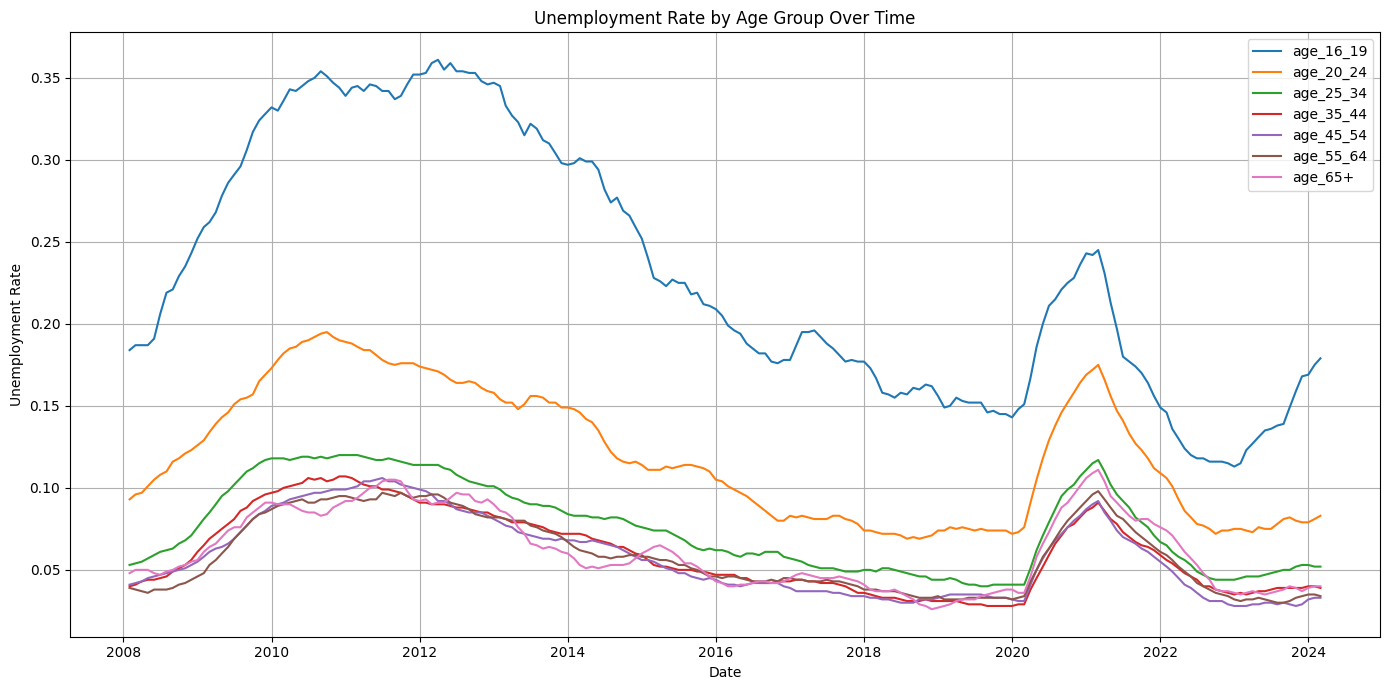

In [ ]:
plt.figure(figsize=(14, 7))
for col in age_columns:
    plt.plot(df['date'], df[col], label=col)

plt.title('Unemployment Rate by Age Group Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

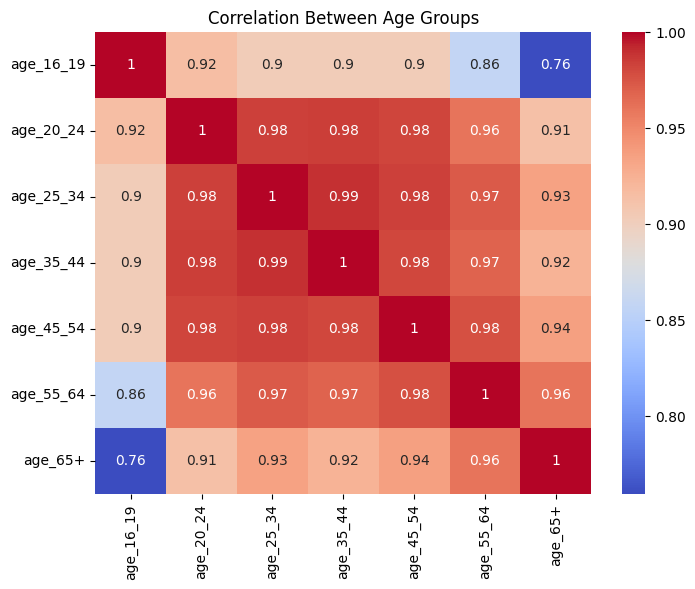

In [ ]:
plt.figure(figsize=(8, 6))
corr = df[age_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Age Groups')
plt.show()

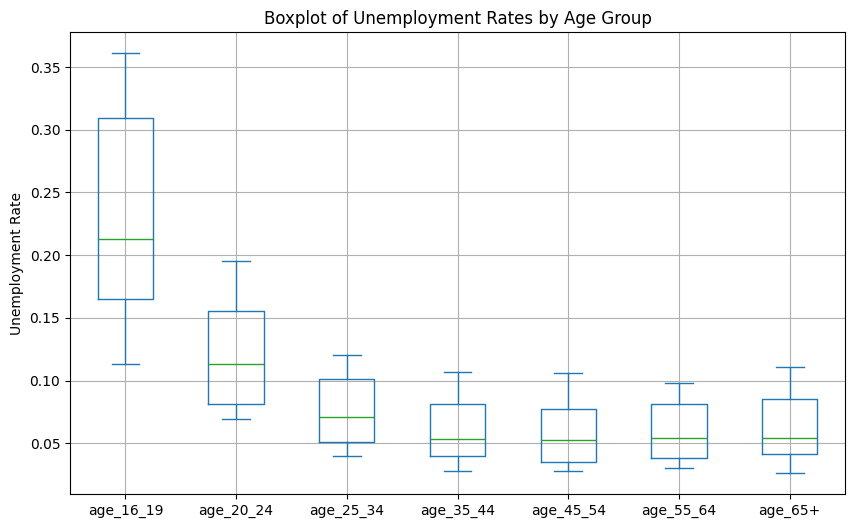

In [ ]:
df[age_columns].plot(kind='box', figsize=(10, 6))
plt.title('Boxplot of Unemployment Rates by Age Group')
plt.ylabel('Unemployment Rate')
plt.grid()
plt.show()

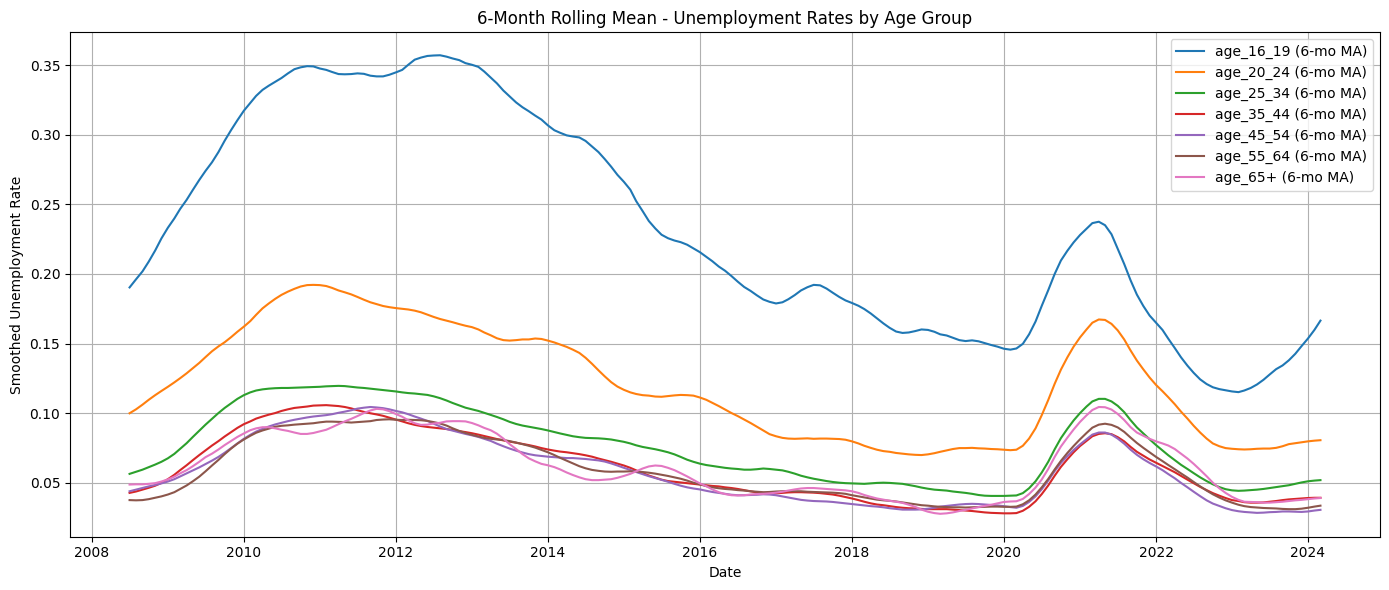

In [ ]:
plt.figure(figsize=(14, 6))
for col in age_columns:
    plt.plot(df['date'], df[col].rolling(window=6).mean(), label=col + ' (6-mo MA)')

plt.title('6-Month Rolling Mean - Unemployment Rates by Age Group')
plt.xlabel('Date')
plt.ylabel('Smoothed Unemployment Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# 3. Normalisasi
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
# 4. Buat window data (X -> y)
def create_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12  # 1 tahun jika data bulanan
X, y = create_sequences(scaled_data, n_steps)

In [ ]:
# 5. Split train-test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# 6. Bangun model LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_steps, len(age_columns))),
    Dropout(0.2),
    Dense(len(age_columns))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,887 (73.78 KB)

 Trainable params: 18,887 (73.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7. Training
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.3207 - val_loss: 0.0357
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0591 - val_loss: 0.0609
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0442 - val_loss: 0.0296
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0348 - val_loss: 0.0285
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0283 - val_loss: 0.0321
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0213 - val_loss: 0.0263
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0236 - val_loss: 0.0265
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0213 - val_loss: 0.0278
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0228 - val_loss: 0.0230
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0183 - val_loss: 0.0300
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0188 - val_loss: 0.0211
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

In [ ]:
# 8. Evaluasi dan Visualisasi
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


In [ ]:
# Hitung RMSE dan MAE untuk tiap kelompok umur
for i, col in enumerate(age_columns):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    print(f"{col} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

age_16_19 - RMSE: 0.0533, MAE: 0.0432
age_20_24 - RMSE: 0.0114, MAE: 0.0089
age_25_34 - RMSE: 0.0068, MAE: 0.0050
age_35_44 - RMSE: 0.0065, MAE: 0.0043
age_45_54 - RMSE: 0.0076, MAE: 0.0063
age_55_64 - RMSE: 0.0039, MAE: 0.0035
age_65+ - RMSE: 0.0065, MAE: 0.0052


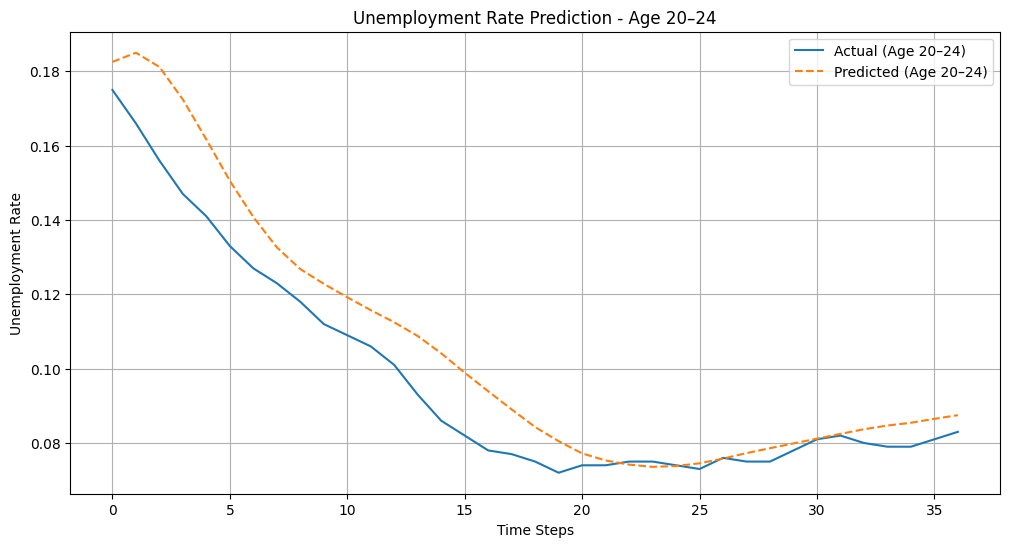

In [ ]:
# Plot prediksi vs aktual (contoh: Age 20–24)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 1], label='Actual (Age 20–24)')
plt.plot(y_pred_inv[:, 1], label='Predicted (Age 20–24)', linestyle='--')
plt.title('Unemployment Rate Prediction - Age 20–24')
plt.xlabel('Time Steps')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


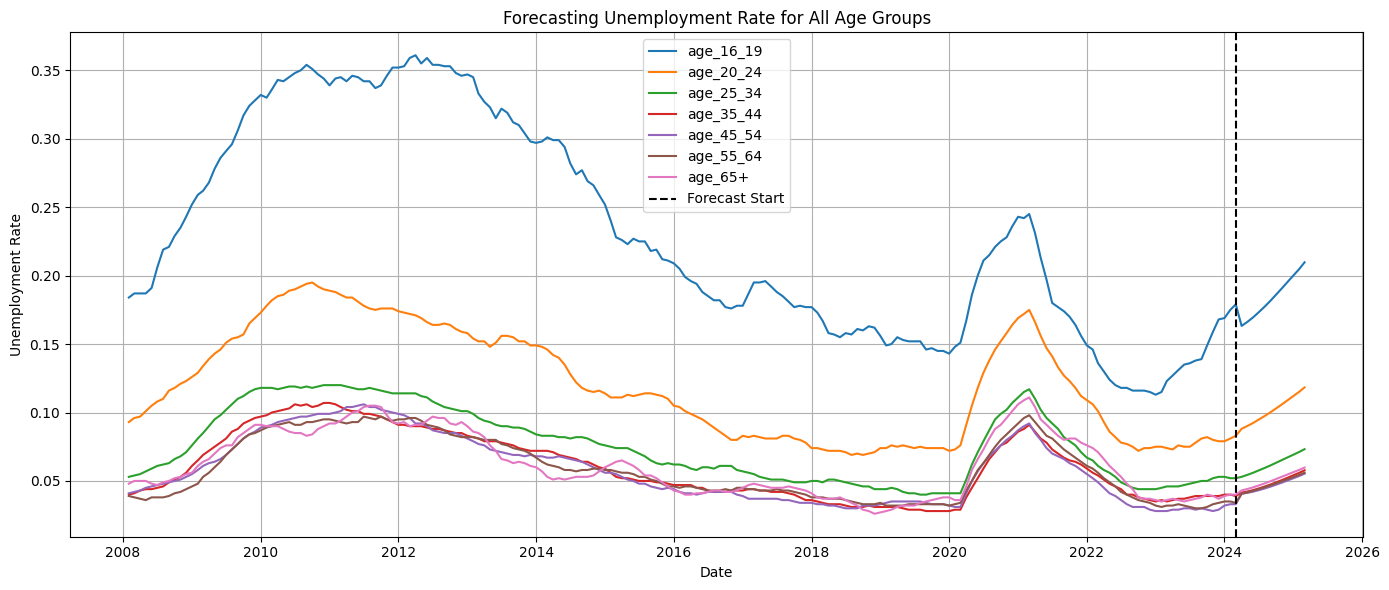

In [ ]:
future_input = scaled_data[-n_steps:].copy()  # shape: (12, 7)

n_future = 12  # bulan ke depan
future_preds = []

for _ in range(n_future):
    input_reshaped = future_input.reshape((1, n_steps, len(age_columns)))
    pred = model.predict(input_reshaped)[0]
    future_preds.append(pred)
    future_input = np.vstack([future_input[1:], pred])  # slide window

# Invers transform hasil
future_preds_inv = scaler.inverse_transform(future_preds)

# Buat DataFrame hasil prediksi
future_dates = pd.date_range(df['date'].iloc[-1] + pd.DateOffset(months=1), periods=n_future, freq='MS')
future_df = pd.DataFrame(future_preds_inv, columns=age_columns)
future_df['date'] = future_dates

# Gabungkan dengan data asli
full_df = pd.concat([df[['date'] + age_columns], future_df], ignore_index=True)

# Plot hasil
plt.figure(figsize=(14, 6))
for col in age_columns:
    plt.plot(full_df['date'], full_df[col], label=col)
plt.axvline(x=df['date'].iloc[-1], color='black', linestyle='--', label='Forecast Start')
plt.title('Forecasting Unemployment Rate for All Age Groups')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan hasil prediksi 12 bulan ke depan
print("Forecasting 12 bulan ke depan:")
print(future_df.round(4).to_string(index=False))

Forecasting 12 bulan ke depan:
 age_16_19  age_20_24  age_25_34  age_35_44  age_45_54  age_55_64  age_65+       date
    0.1633     0.0881     0.0530     0.0415     0.0407     0.0407   0.0431 2024-04-01
    0.1661     0.0901     0.0544     0.0423     0.0413     0.0416   0.0441 2024-05-01
    0.1695     0.0924     0.0560     0.0433     0.0422     0.0428   0.0453 2024-06-01
    0.1733     0.0948     0.0577     0.0445     0.0432     0.0440   0.0467 2024-07-01
    0.1773     0.0974     0.0595     0.0459     0.0445     0.0454   0.0482 2024-08-01
    0.1816     0.1002     0.0613     0.0474     0.0458     0.0468   0.0498 2024-09-01
    0.1861     0.1030     0.0633     0.0490     0.0473     0.0482   0.0514 2024-10-01
    0.1908     0.1060     0.0652     0.0507     0.0488     0.0497   0.0531 2024-11-01
    0.1954     0.1090     0.0672     0.0524     0.0504     0.0513   0.0548 2024-12-01
    0.2001     0.1121     0.0692     0.0542     0.0520     0.0529   0.0565 2025-01-01
    0.2049     0.1152  